# Wasserstein Gradient Flow using Sinkhorn's Algorithm
Let us test the Sinkhorn implementation. The following section of the code implements several visualization tools for marginals, cost matrices, and optimal coupling.

In [ ]:
from src.jko_lab import *
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
from jax import lax
import optax
from __future__ import annotations
from typing import Callable, Optional, Tuple, List
import flax.struct as flstr
Array = jnp.ndarray

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def animate_hist_flow(
    mu_list,
    x,
    target=None,                 # optional target mass/density: same length as x
    interval=200,                # ms between frames
    title="Gradient Flow",
    xlabel="x",
    ylabel="Probability Density",
    bar_alpha=0.5,
    bar_edge="black",
    bar_color=None,              # None -> Matplotlib default
    line_color="red",
    ylim_pad=1.1,                # y-axis headroom factor
    return_html=True,            # return HTML string for display in notebooks
):
    """
    Animate a sequence of 1D measures as a bar 'histogram' over a fixed grid.

    Args
    ----
    mu_list : array-like, shape (T, n) or list of (n,)
        Sequence of measures (bin masses). Each frame will be normalized to sum=1.
    x : array-like, shape (n,)
        Bin centers (uniformly spaced).
    target : array-like, shape (n,), optional
        Target distribution. If supplied, it's plotted as a line (interpreted as mass; converted to density).
    interval : int
        Milliseconds between frames.
    title, xlabel, ylabel : str
        Labels.
    bar_alpha, bar_edge, bar_color : visual args for bars.
    line_color : color for the target curve.
    ylim_pad : float
        Multiplier for max y to add headroom.
    return_html : bool
        If True, return HTML string from ani.to_jshtml(); else return the Matplotlib Animation object.

    Returns
    -------
    HTML string (if return_html=True) or the Animation object.
    """
    # Convert to numpy (handles JAX arrays)
    mu_arr = np.asarray(mu_list)
    x = np.asarray(x)
    T, n = mu_arr.shape

    # Uniform bin width from centers
    if n < 2:
        raise ValueError("x must have at least 2 points to infer bin width.")
    bin_width = float(x[1] - x[0])

    # Densities for initial frame
    y0 = mu_arr[0] / np.sum(mu_arr[0])
    y0_density = y0 / bin_width

    # Optional target (mass or density -> convert to density)
    target_density = None
    if target is not None:
        tgt = np.asarray(target)
        if tgt.shape != (n,):
            raise ValueError("target must have shape (n,), same length as x.")
        # If target sums to ~1, treat as mass; otherwise assume it's already density
        if 0.9 <= float(np.sum(tgt)) <= 1.1:
            target_density = tgt / (np.sum(tgt) * bin_width)
        else:
            target_density = tgt

    # Figure/axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars at bin centers with width=bin_width
    bars = ax.bar(
        x, y0_density, width=bin_width, alpha=bar_alpha,
        align="center", edgecolor=bar_edge, color=bar_color, label="Distribution"
    )

    # Overlay target curve if provided
    if target_density is not None:
        (target_line,) = ax.plot(x, target_density, color=line_color, lw=2, label="Target Distribution")
    else:
        target_line = None

    # Axis limits
    y_max = y0_density.max()
    if target_density is not None:
        y_max = max(y_max, float(np.max(target_density)))
    ax.set_xlim(x.min() - 0.5 * bin_width, x.max() + 0.5 * bin_width)
    ax.set_ylim(0, y_max * ylim_pad)

    # Labels and legend
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title} — step 0 / {T-1}")
    ax.legend()

    # Init function: zero bars (optional eye-candy)
    def init():
        for b in bars:
            b.set_height(0.0)
        return bars

    # Update per frame
    def animate(i):
        yi = mu_arr[i]
        yi = yi / np.sum(yi)            # normalize to probability mass 1
        yi_density = yi / bin_width      # convert to density
        for b, h in zip(bars, yi_density):
            b.set_height(float(h))
        ax.set_title(f"{title} — step {i} / {T-1}")
        return bars

    ani = animation.FuncAnimation(
        fig, animate, frames=np.arange(T), init_func=init,
        interval=interval, blit=True
    )
    plt.close(fig)  # avoid static figure in notebooks

    if return_html:
        return HTML(ani.to_jshtml())
    return ani

Let $X=Y=\mathbb{R}^n$ where $n=500$. Take the squared Euclidean cost matrix $C:\mathbb{R}^{n \times n} \to \mathbb{R}$ given by $$C(x,y)=\vert x-y\vert^2$$Consider two Gaussian probability vectors, source $\rho^k$ and target $\rho$ marginals,
$$
\rho^k = \mathcal{N}(\mu=0.3, \sigma^2=0.05) \\
\rho = \mathcal{N}(\mu=0.7, \sigma^2=0.05)
$$

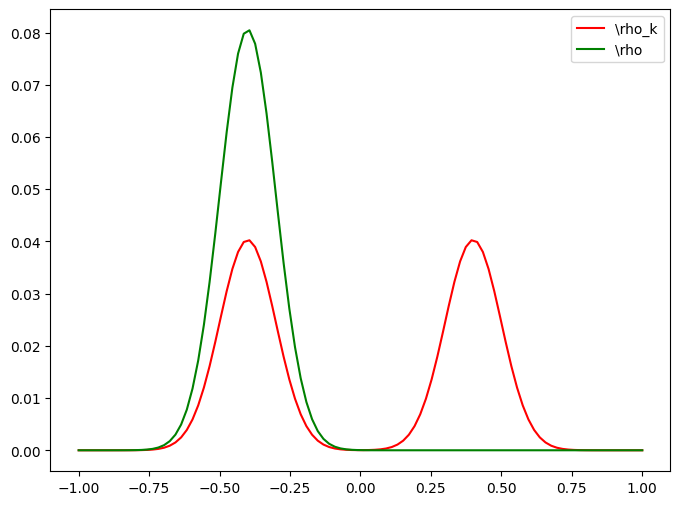

In [ ]:
key = jax.random.PRNGKey(42)
n = 100

# 1D grid on [0,1]
x = jnp.linspace(0, 1, n)
C = (x[:,None] - x[None,:])**2 # cost matrix

# Target marginal rho_k (right marginal), a bimodal distribution
rho_k = 0.5 * jax.scipy.stats.norm.pdf(x, 0.3, 0.05) + 0.5 * jax.scipy.stats.norm.pdf(x, 0.7, 0.05)
rho_k = jnp.clip(rho_k, 1e-12, None)
rho_k = rho_k / rho_k.sum()

rho = jax.scipy.stats.norm.pdf(x, 0.3, 0.05)
rho = jnp.clip(rho, 1e-12, None)
rho = rho / rho.sum()

COLORS = ["red", "green", "blue", "orange", "purple"]

def plot_vectors(n: int, data: dict):
    """
    Plots vectors supported on [-5,5] with respect to labels.
    """
    x = jnp.linspace(-1, 1, n)
    fig = plt.figure(figsize=(8, 6))
    i = 0
    for label, vec in data.items():
        plt.plot(x, vec, label=rf'\{label}', color=COLORS[i])
        i += 1
    plt.legend()

plot_vectors(n, {
    "rho_k": rho_k,
    "rho": rho
    })

We solve the entropy-regularized optimal transport problem
$$
\arg\min \langle C, \pi\rangle + \varepsilon H(\pi)
$$
with $\mathrm{rs}(\pi)=\rho^k$, $\mathrm{cs}(\pi)=\rho$ via Sinkhorn algorithm.

In [ ]:
eta = 1e-2 # JKO step size
epsilon = 1e-6 # Sinkhorn regularization parameter

# Run solver
solver = Sinkhorn(
    C=C,
    a=rho,
    b=rho_k,
    epsilon=epsilon,
    max_iters=1000,
    tol=1e-9,
    f = None,
    g = None
)

# extract outputs
pi, f, g, error, iters = solver.solve()
col_sums(pi)
# print basic info
print("Column feasibility ||pi^T 1 - rho_k||:", float(jnp.linalg.norm(col_sums(pi) - rho_k)))
print("Mass check (should be 1):", float(rho.sum()))


NameError: name 'col_sums' is not defined

The performance of the algorithm is measured by the following.

Plot 1: Marginals
Plot 2: Cost matrix
Plot 3: Transport plan


Text(0.5, 1.02, 'Summary of Sinkhorn Algorithm')

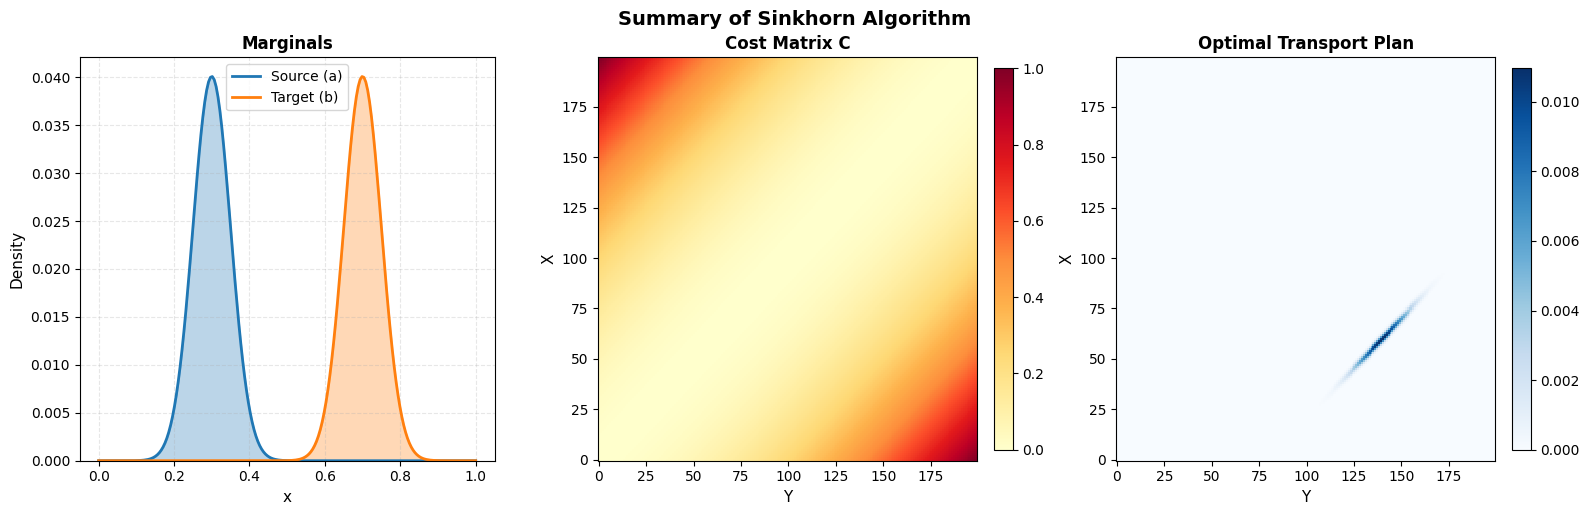

In [ ]:
# Create summary
fig = plot_sinkhorn_summary(
    C=C,
    a=rho,
    b=rho_k,
    pi=pi,
    x_source=x,
    x_target=x,
    figsize=(16, 5)
)
plt.suptitle(f'Summary of Sinkhorn Algorithm', fontsize=14, fontweight='bold', y=1.02)

The following wrapper function computes squared entropy-regularized 2-Wasserstein distance using warm-start Sinkhorn's algorithm.
$$
W_{2,\epsilon}^2(\rho,\rho^k) = \underset{\gamma \to \Pi(\rho,\rho^k)}{\inf}\left\{ \int_{X\times X} C(x,y) d\gamma + \epsilon\int_{X\times X} \frac{d\gamma}{d(\rho \otimes \rho^k)} \log\left(\frac{d\gamma}{d(\rho \otimes \rho^k)}\right) - \frac{d\gamma}{d(\rho \otimes \rho^k)} d\gamma \right\}
$$
Here, we provide an extra argument to the Sinkhorn algorithm that is a Kantorovich potentials $u, v \in C(X)$. Starting from these two dual potentials, and current marginal probability distribution $\rho \in \mathcal{P}(X)$, we approximate the 2-Wasserstein distance.

From the definition of Wasserstein gradient flow, we will use SGD from optax in search for a minimizer $\rho \in \mathcal{P}(X)$ of the functional $$\rho^{k+1} = \mathcal{G}[\rho] = F[\rho] + \frac{1}{2\tau}W_{2,\epsilon}^2(\rho,\rho^k).$$ As this is a constrained minimization problem over a probability simplex, we instead minimize an unconstrained counterpart $\mathcal{G}\circ \textrm{softmax}$. Then, after a number of SGD iterations, we get approximately $\rho^{k+1}$ the minimizer and the next step of JKO scheme. Correct me if I'm wrong, and I would like to know how I may be able to implement this algorithm inside my `sinkhorn_jko.py` file.

In [ ]:
# Choose F = entropy (negative Boltzmann-Shannon)
def F_value_entropy(rho: jax.Array) -> jax.Array:
    rho_safe = jnp.clip(rho, 1e-12, None) # prevent log(0)
    return jnp.sum(rho_safe * (jnp.log(rho_safe) - 1.0))

Test 1: Shannon Entropy
Computing flow...
✓ Completed in 23.43s
 Total number of measures: 51
  Initial entropy: 3.716511
  Final entropy: 1.491926


In [ ]:
# Test: 2-point analytic trend
C2 = jnp.array([[0.0, 1.0], [1.0, 0.0]])
a = 0.2
rho_k2p = jnp.array([a,1-a])
b1 = 0.8
b_vec = jnp.array([b1, 1-b1])

def F_quadratic(alpha, b=b_vec, lamb=1.0):
    return lamb/2*alpha*jnp.linalg.norm(x-b)**2

In [ ]:
n = 32
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

# Non-uniform initial distribution
rho0 = 0.75 * jax.scipy.stats.norm.pdf(x, 0.3, 0.05) + 0.25 * jax.scipy.stats.norm.pdf(x, 0.8, 0.03)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

b = jnp.ones_like(x)/n
lam = 1.0
def F_quad(x,alpha,b=b, lam=lam):
    return lam*2*alpha*jnp.linalg.norm(x-b)**2

rhos, feas = SinkhornJKO(
    C=C,
    rho0=rho0,
    eta=eta,
    epsilon=epsilon,
    F_func=F_quad,
    sinkhorn_iters=500,
    inner_steps=20,
    tol=1e-9,
    learning_rate=0.01,
    optimizer_name='adam'
)
dists = jnp.linalg.norm(rhos-b[None, :], axis=1)
print("[Flow-Quadratic] ||rho^k - b|| should decrease:")
for k in [0,1,5,10,20,30,50]:
    if k<=50:
        print(f" k={k:2d}: ||rho-b||={float(dists[k]):.6f}")
print(" max column feasibility over steps:", float(jnp.max(feas)))

html = animate_hist_flow(
    mu_list=rhos,
    x=np.asarray(x),
    target=b,
    interval=150,
    title="JKO FLow (porous + V)"
)
html

Next example is constructed via using Shannon entropy as an external potential function.

In [ ]:
n = 64
x = jnp.linspace(0.0, 1.0, n)
X, Y = jnp.meshgrid(x, x, indexing="ij")
C = (X - Y) ** 2

rho0 = 0.7 * jax.scipy.stats.norm.pdf(x, 0.25, 0.03) + 0.3 * jax.scipy.stats.norm.pdf(x, 0.75, 0.04)
rho0 = jnp.clip(rho0, 1e-12, None); rho0 = rho0 / rho0.sum()

def entropy(r):
    r = jnp.clip(r, 1e-12, None)
    return -jnp.sum(r * jnp.log(r))

rhos, feas = jko_flow(C, rho0, eta=0.05, proxF=proxF_entropy, proxF_kwargs=dict(eps=0.0),
num_steps=30, inner_iters=1000)
b = jnp.ones_like(x)/n
dists = jnp.linalg.norm(rhos - b[None, :], axis=1)
Hs = jnp.array([entropy(r) for r in rhos])

print("[Flow-Entropy] Entropy should increase, distance to uniform should decrease:")
for k in [0, 1, 5, 10, 20, 30]:
    if k <= 30:
        print(f" k={k:2d}: H={float(Hs[k]):.6f}, ||rho-b||={float(dists[k]):.6f}")
print(" max column feasibility over steps:", float(jnp.max(feas)))

In [ ]:
b

Array([0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125], dtype=float64)

In [ ]:
# ...existing code...
# ensure animation grid matches rhos
x = jnp.linspace(0.0, 1.0, rhos.shape[1])   # use rhos' spatial resolution
b = jnp.ones_like(x) / float(x.size)         # uniform target on same grid

animate_hist_flow(rhos, x=np.asarray(x),
    target=np.asarray(b),
    interval=150,
    title="JKO Flow (porous + V)"
)
# ...existing code...